# Project work in NLP
student : Yuwei Ke

ID : 0000977066

# Data loading and processing

In [ ]:
!pip uninstall tensorflow --yes
!pip uninstall tensorflow_text --yes
!pip install tensorflow==2.8.4
import tensorflow as tf
print(tf.__version__)
!pip install tensorflow-text==2.8.1
import tensorflow_text
!pip install --upgrade tensorflow_hub
!pip install gensim==4.0.0
import tensorflow_hub as hub     
!pip install -q tf-models-official==2.7.0
print("Environmental packages imported")

Found existing installation: tensorflow 2.9.2
Uninstalling tensorflow-2.9.2:
  Successfully uninstalled tensorflow-2.9.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.0/498.0 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 KB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 80.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 85.3 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling 

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from typing import List, Callable, Dict

import re
from functools import reduce
import nltk
from nltk.corpus import stopwords

from collections import OrderedDict
import gensim
import gensim.downloader as gloader

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model,load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
from functools import partial
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from keras.utils.vis_utils import plot_model
from IPython.display import Image as IPythonImage
from IPython.display import display

from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from official.nlp import optimization 

/usr/local/lib/python3.8/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in Tens

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#load data
data = pd.read_csv('/content/drive/My Drive/nlp-project/dataset/train-balanced-sarcasm.csv')
data.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [ ]:
#delete the unused row 
data = data.drop(['subreddit','author','score','ups','downs','date','created_utc'], axis=1)
data.head()

,label,comment,parent_comment
0,0,NC and NH.,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",deadass don't kill my buzz
4,0,I could use one of those tools.,Yep can confirm I saw the tool they use for th...


In [ ]:
print("Data shape before deleting the row with NAN value: ",data.shape)
data = data.dropna(axis=0,how='any')
print("Data shape after deleting the row with NAN value: ",data.shape)

Data shape before deleting the row with NAN value:  (1010826, 3)
Data shape after deleting the row with NAN value:  (1010773, 3)


In [ ]:
# get 100000 data 
data_pos = data[data['label'] == 1][:50000]
data_neg = data[data['label'] == 0][:50000]
data = pd.concat([data_pos,data_neg])

In [ ]:
label = data['label']
data.drop(['label'],axis=1)
label.value_counts()

1    50000
0    50000
Name: label, dtype: int64

Split the data

In [ ]:
train_data, test_data, train_label, test_label = train_test_split(data, label, test_size=10000, random_state=42 ,stratify=label)
train_data, val_data, train_label, val_label = train_test_split(train_data,train_label, test_size=10000, random_state=42 ,stratify=train_label)

print(train_label.value_counts())
print(test_label.value_counts())
print(val_label.value_counts())

train_data_comment = train_data.comment
train_data_parent_comment = train_data.parent_comment
test_data_comment = test_data.comment
test_data_parent_comment = test_data.parent_comment
val_data_comment = val_data.comment
val_data_parent_comment = val_data.parent_comment

print('Train comment data: ', train_data_comment.shape)
print('Train parent comment: ', train_data_parent_comment.shape)
print('Train label: ', train_label.shape)
print('Test comment data: ', test_data_comment.shape)
print('Test parent comment: ', test_data_parent_comment.shape)
print('Test label: ', test_label.shape)
print('Val comment data: ', val_data_comment.shape)
print('Val parent comment: ', val_data_parent_comment.shape)
print('Val label: ', val_label.shape)

1    40000
0    40000
Name: label, dtype: int64
0    5000
1    5000
Name: label, dtype: int64
0    5000
1    5000
Name: label, dtype: int64
Train comment data:  (80000,)
Train parent comment:  (80000,)
Train label:  (80000,)
Test comment data:  (10000,)
Test parent comment:  (10000,)
Test label:  (10000,)
Val comment data:  (10000,)
Val parent comment:  (10000,)
Val label:  (10000,)


text preprocessing

In [ ]:
#text-preprocessing

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;.:`\-\'\"]')
GOOD_SYMBOLS_RE = re.compile('[^0-9a-zA-Z #+_]')

try:
    STOPWORDS = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    STOPWORDS = set(stopwords.words('english'))

def lower(text: str) -> str:
    return text.lower()

def replace_special_characters(text: str) -> str:
    return REPLACE_BY_SPACE_RE.sub(' ', text)

def remove_blank(text: str) -> str:
  return text.sub(r's\+','')

def removeWordsWithNumbers(text):
    return re.sub(r'\S*\d\S*', '', text).strip()

def filter_out_uncommon_symbols(text: str) -> str:
    return GOOD_SYMBOLS_RE.sub('', text)


def remove_stopwords(text: str) -> str:
    return ' '.join([x for x in text.split() if x and x not in STOPWORDS])


def strip_text(text: str) -> str:
    return text.strip()

def split_text(text: str) -> str:
    return text.split()

def removeLinks(text):
    text = re.sub(r'http\S+','', text, flags=re.MULTILINE)
    return text

def removeHTMLTags(text):
    text = re.sub(r'<.*?>', '', text, flags=re.MULTILINE)
    return text

def decontracted(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

PREPROCESSING_PIPELINE = [
                          decontracted,
                          removeLinks,
                          removeHTMLTags,
                          removeWordsWithNumbers,
                          replace_special_characters,
                          filter_out_uncommon_symbols,
                          lower,
                          strip_text,
                          split_text
                          ]

PREPROCESSING_PIPELINE_BERT = [
                          removeLinks,
                          removeHTMLTags,
                          lower,
                          strip_text
                          ]

def text_prepare(text: str,filter_methods=PREPROCESSING_PIPELINE):
    return reduce(lambda x, f: f(x), filter_methods, text)

print('Pre-processing text...')
print('Before:\n{}'.format(train_data.comment[:3]))
#for bert
train_comment_bert = train_data_comment.apply(lambda x: text_prepare(x,PREPROCESSING_PIPELINE_BERT))
train_data_parent_comment_bert = train_data_parent_comment.apply(lambda x: text_prepare(x,PREPROCESSING_PIPELINE_BERT))
test_data_comment_bert = test_data_comment.apply(lambda x: text_prepare(x,PREPROCESSING_PIPELINE_BERT))
test_data_parent_comment_bert = test_data_parent_comment.apply(lambda x: text_prepare(x,PREPROCESSING_PIPELINE_BERT))
val_data_comment_bert = val_data_comment.apply(lambda x: text_prepare(x,PREPROCESSING_PIPELINE_BERT))
val_data_parent_comment_bert = val_data_parent_comment.apply(lambda x: text_prepare(x,PREPROCESSING_PIPELINE_BERT))

# for cnn and lstm
train_comment = train_data_comment.apply(lambda x: text_prepare(x))
train_parent_comment = train_data_parent_comment.apply(lambda x: text_prepare(x))
test_comment = test_data_comment.apply(lambda x: text_prepare(x))
test_parent_comment = test_data_parent_comment.apply(lambda x: text_prepare(x))
val_comment = val_data_comment.apply(lambda x: text_prepare(x))
val_parent_comment = val_data_parent_comment.apply(lambda x: text_prepare(x))

print('After:\n{}'.format(train_comment_bert[:3]))
print('After:\n{}'.format(train_comment[:3]))
print("Pre-processing completed!")

Pre-processing text...
Before:
114883    Sorry guys... forgot this.
72858            But Rule 6, though.
26005                 You forgot the
Name: comment, dtype: object


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


After:
114883    sorry guys... forgot this.
72858            but rule 6, though.
26005                 you forgot the
Name: comment, dtype: object
After:
114883    [sorry, guys, forgot, this]
72858             [but, rule, though]
26005              [you, forgot, the]
Name: comment, dtype: object
Pre-processing completed!


Vocabulary creation

In [ ]:
def build_vocabulary(df):

    idx_to_word = OrderedDict()
    word_to_idx = OrderedDict()
    curr_idx = 0

    for sentence in tqdm(df.values):
        tokens = sentence
        for token in tokens:
          if token not in word_to_idx:
              word_to_idx[token] = curr_idx
              idx_to_word[curr_idx] = token
              curr_idx += 1

    word_listing = list(idx_to_word.values())
    return idx_to_word, word_to_idx, word_listing

corpus = pd.concat([train_comment,val_comment],ignore_index=True)
idx_to_word, word_to_idx, word_listing = build_vocabulary(corpus)

print('Index -> Word vocabulary size: {}'.format(len(idx_to_word)))
print('Word -> Index vocabulary size: {}'.format(len(word_to_idx)))
print('The corpus length: {}'.format(len(word_listing)))
print('Some words: {}'.format([(idx_to_word[idx], idx) for idx in np.arange(10) + 1]))


100%|██████████| 90000/90000 [00:00<00:00, 594724.90it/s]

Index -> Word vocabulary size: 44193
Word -> Index vocabulary size: 44193
The corpus length: 44193
Some words: [('guys', 1), ('forgot', 2), ('this', 3), ('but', 4), ('rule', 5), ('though', 6), ('you', 7), ('the', 8), ('cranbrook', 9), ('she', 10)]


In [ ]:
#download the glove
embedding_dimension = 300
download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)

try:
    embedding_model = gloader.load(download_path)
except ValueError as e:
    print("Invalid embedding model name! Check the embedding dimension:")
    print("Glove: 50, 100, 200, 300")
    raise e


[==================================================] 100.0% 376.1/376.1MB downloaded


In [ ]:
# check oov terms 
def check_OOV_terms(embedding_model,word_listing):
    embedding_vocabulary = set(embedding_model.key_to_index.keys())
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

oov_terms = check_OOV_terms(embedding_model, word_listing)
print("Total OOV terms: {0} ({1:.2f}%)".format(len(oov_terms), float(len(oov_terms)) / len(word_listing)*100))

Total OOV terms: 10291 (23.29%)


In [ ]:
oov_token = "<OOV>"
tokenizer = Tokenizer(oov_token=oov_token)
tokenizer.fit_on_texts(corpus)

vocabLength = len(tokenizer.word_index)+1 
print("Tokenizer vocabulary length: {}".format(vocabLength))

Tokenizer vocabulary length: 44195


In [ ]:
def build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                           embedding_dimension: int,
                           word_to_idx: Dict[str, int]):

    embedding_matrix = np.zeros((len(word_to_idx)+1, embedding_dimension))
    for word, i in tqdm(word_to_idx.items()):
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[i] = embedding_vector

    return embedding_matrix

embedding_matrix = build_embedding_matrix(embedding_model, embedding_dimension, tokenizer.word_index)

print("Embedding matrix shape: {}".format(embedding_matrix.shape))

100%|██████████| 44194/44194 [00:00<00:00, 207147.30it/s]

Embedding matrix shape: (44195, 300)


In [ ]:
def convert_text(texts, tokenizer,max_seq_length):
    text_ids = tokenizer.texts_to_sequences(texts)
    text_ids = pad_sequences(text_ids, padding='post', truncating='post', maxlen=max_seq_length,dtype='float32')

    return text_ids

max_seq_length = 300
print("Max sentence length is: {} words".format(max_seq_length))

# Train
train_comment = convert_text(train_comment, tokenizer, max_seq_length)

print(train_comment[:1])
print('Train comment shape: ', train_comment.shape)
print('Train label shape: ', train_label.shape)

# Val
val_comment = convert_text(val_comment, tokenizer, max_seq_length)
print('Val comment shape: ', val_comment.shape)
print('Val label shape: ', val_label.shape)

# Test
test_comment = convert_text(test_comment, tokenizer, max_seq_length)
print('Test comment shape: ', test_comment.shape)
print('Test label shape: ', test_label.shape)

Max sentence length is: 300 words
[[266. 182. 124.  18.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0

# CNN

In [ ]:
def create_cnn_model(compile_info):

    #input layer
    commentInput=Input(shape=(max_seq_length,))
    embedding_comment = Embedding(input_dim = vocabLength,
                                output_dim = embedding_dimension,
                                weights= [embedding_matrix],
                                input_length=max_seq_length,
                                name = "embedding_comment")(commentInput)
    conv_comm_1 = Conv1D(filters=50, kernel_size=4, activation='relu')(embedding_comment)
    max_comm_1 = MaxPooling1D(pool_size=2)(conv_comm_1)
    conv_comm_2 = Conv1D(filters=100, kernel_size=3, activation='relu')(max_comm_1)
    max_comm_2 = MaxPooling1D(pool_size=2)(conv_comm_2)
    flatten = Flatten()(max_comm_2)
    dense = Dense(100, activation='relu', name='fully_connected')(flatten)
    dropout = Dropout(0.2)(dense)
    out = Dense(1, activation='sigmoid')(dropout)

    model = Model(inputs=commentInput, outputs=out)  
    model.summary()
    model.compile(**compile_info)

    return model

modelCNN = create_cnn_model(compile_info)

Model: "model"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 300)]             0         

                                                                 

 embedding_comment (Embeddin  (None, 300, 300)         13258500  

 g)                                                              

                                                                 

 conv1d (Conv1D)             (None, 297, 50)           60050     

                                                                 

 max_pooling1d (MaxPooling1D  (None, 148, 50)          0         

 )                                                               

                                                                 

 conv1d_1 (Conv1D)           (None, 146, 100)          15100     

                                                                 

 max_pooling1d_1 (MaxPooling  (None, 73, 100)

In [ ]:
compile_info = {
    'optimizer': keras.optimizers.Adam(learning_rate=5e-5),
    'loss': 'binary_crossentropy',
    'metrics': ['accuracy'],
}
earlyStopping = EarlyStopping(monitor='val_loss',mode='min',patience=10,restore_best_weights=True)
training_info = {
    'verbose': 1,
    'epochs': 40,
    'batch_size': 32,
    'callbacks': [earlyStopping]
}

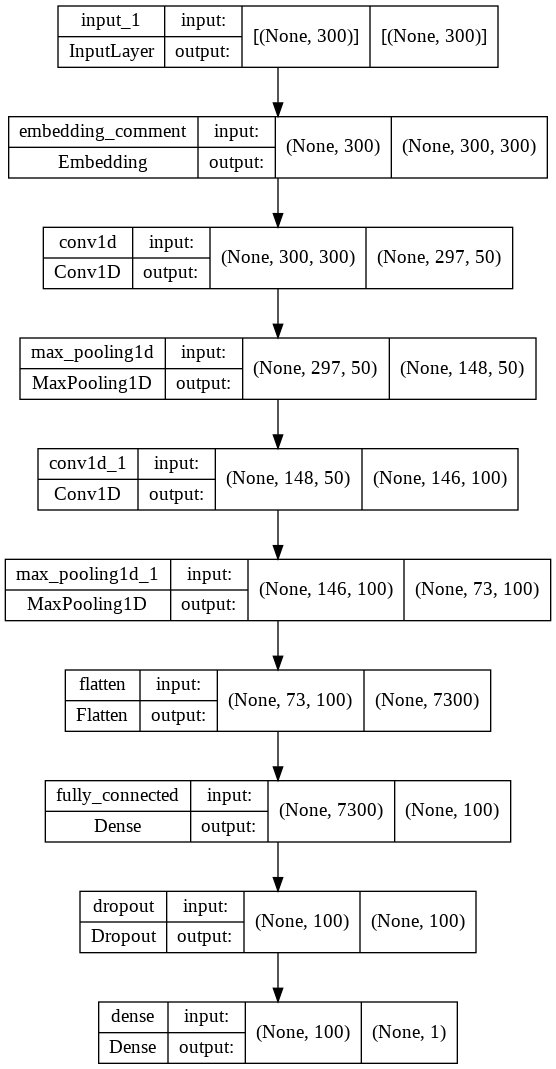

In [ ]:
plot_model(modelCNN, to_file="model.png", show_shapes=True)
display(IPythonImage('model.png'))

In [ ]:
historyCNN = modelCNN.fit(x=train_comment, y=train_label,
                        validation_data=(val_comment, val_label),
                        **training_info)

Epoch 1/40

2500/2500 [==============================] - 41s 13ms/step - loss: 0.6622 - accuracy: 0.5954 - val_loss: 0.6323 - val_accuracy: 0.6401

Epoch 2/40

2500/2500 [==============================] - 32s 13ms/step - loss: 0.6088 - accuracy: 0.6647 - val_loss: 0.6100 - val_accuracy: 0.6611

Epoch 3/40

2500/2500 [==============================] - 32s 13ms/step - loss: 0.5732 - accuracy: 0.6967 - val_loss: 0.6025 - val_accuracy: 0.6758

Epoch 4/40

2500/2500 [==============================] - 32s 13ms/step - loss: 0.5420 - accuracy: 0.7231 - val_loss: 0.6029 - val_accuracy: 0.6797

Epoch 5/40

2500/2500 [==============================] - 32s 13ms/step - loss: 0.5074 - accuracy: 0.7502 - val_loss: 0.6119 - val_accuracy: 0.6767

Epoch 6/40

2500/2500 [==============================] - 32s 13ms/step - loss: 0.4688 - accuracy: 0.7778 - val_loss: 0.6289 - val_accuracy: 0.6745

Epoch 7/40

2500/2500 [==============================] - 32s 13ms/step - loss: 0.4281 - accuracy: 0.8032 - val_l

In [ ]:
resultCNN = modelCNN.evaluate(test_comment,test_label, batch_size=32)
resultCNN

313/313 [==============================] - 1s 4ms/step - loss: 0.6074 - accuracy: 0.6655


[0.6073542237281799, 0.6654999852180481]

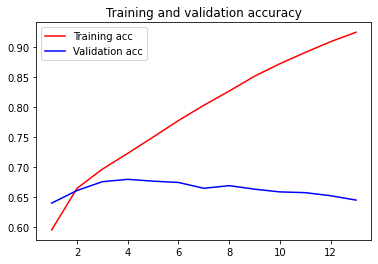

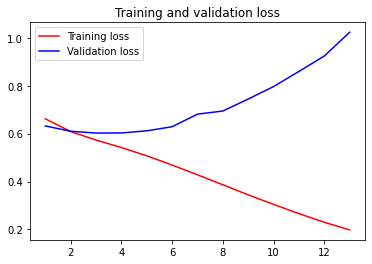

In [ ]:
## Plotting results
def plot(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)
    ## Accuracy plot
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    ## Loss plot
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

plot(historyCNN)

In [ ]:
test_prediction=modelCNN.predict(test_comment)
test_prediction = np.round(test_prediction,0).astype(np.int32)
report = classification_report(test_label, test_prediction, zero_division=True,labels=[0,1], target_names=["non-sarcastic","sarcastic"])
print(report)

               precision    recall  f1-score   support



non-sarcastic       0.64      0.76      0.69      5000

    sarcastic       0.70      0.57      0.63      5000



     accuracy                           0.67     10000

    macro avg       0.67      0.67      0.66     10000

 weighted avg       0.67      0.67      0.66     10000




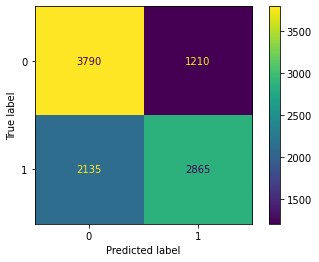

In [ ]:
cf_matrix = confusion_matrix(test_label,test_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,display_labels=[0,1])
disp.plot()
plt.show()

# LSTM

In [ ]:
def create_lstm_model(compile_info):

    #input layer
    commentInput=Input(shape=(max_seq_length,))
    embedding_comment = Embedding(input_dim = vocabLength,
                                output_dim = embedding_dimension,
                                weights= [embedding_matrix],
                                input_length=max_seq_length,
                                name = "embedding_comment")(commentInput)
  
    lstm_comm_1 = Bidirectional(LSTM(128))(embedding_comment)
    dense = Dense(128, activation='relu', name='fully_connected')(lstm_comm_1)
    dropout_output = Dropout(0.2)(dense) 
    out = Dense(1, activation='sigmoid')(dropout_output)

    model = Model(inputs=[commentInput], outputs=out)  
    model.summary()
    model.compile(**compile_info)

    return model

modelLSTM = create_lstm_model(compile_info)

Model: "model_2"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 input_3 (InputLayer)        [(None, 300)]             0         

                                                                 

 embedding_comment (Embeddin  (None, 300, 300)         13258500  

 g)                                                              

                                                                 

 bidirectional_1 (Bidirectio  (None, 256)              439296    

 nal)                                                            

                                                                 

 fully_connected (Dense)     (None, 128)               32896     

                                                                 

 dropout_2 (Dropout)         (None, 128)               0         

                                                                 

 dense_2 (Dense)             (None, 1)     

In [ ]:
compile_info_lstm = {
    'optimizer': keras.optimizers.Adam(learning_rate=1e-4),
    'loss': 'binary_crossentropy',
    'metrics': ['accuracy'],
}
earlyStopping = EarlyStopping(monitor='val_loss',mode='min',patience=10,restore_best_weights=True)
training_info = {
    'verbose': 1,
    'epochs': 40,
    'batch_size': 32,
    'callbacks': [earlyStopping]
}

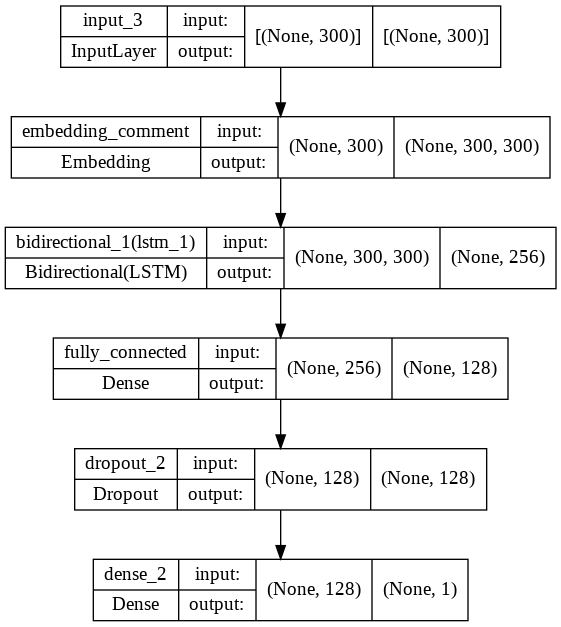

In [ ]:
plot_model(modelLSTM, to_file="modellstm.png", show_shapes=True)
display(IPythonImage('modellstm.png'))

In [ ]:
historyLSTM = modelLSTM.fit(x=train_comment, y=train_label,
                        validation_data=(val_comment, val_label),
                        **training_info)

Epoch 1/40

2500/2500 [==============================] - 107s 42ms/step - loss: 0.6275 - accuracy: 0.6423 - val_loss: 0.6069 - val_accuracy: 0.6623

Epoch 2/40

2500/2500 [==============================] - 99s 40ms/step - loss: 0.5873 - accuracy: 0.6857 - val_loss: 0.5949 - val_accuracy: 0.6719

Epoch 3/40

2500/2500 [==============================] - 100s 40ms/step - loss: 0.5649 - accuracy: 0.7047 - val_loss: 0.5868 - val_accuracy: 0.6826

Epoch 4/40

2500/2500 [==============================] - 102s 41ms/step - loss: 0.5450 - accuracy: 0.7215 - val_loss: 0.5851 - val_accuracy: 0.6909

Epoch 5/40

2500/2500 [==============================] - 102s 41ms/step - loss: 0.5241 - accuracy: 0.7384 - val_loss: 0.5921 - val_accuracy: 0.6909

Epoch 6/40

2500/2500 [==============================] - 101s 41ms/step - loss: 0.5023 - accuracy: 0.7544 - val_loss: 0.5957 - val_accuracy: 0.6924

Epoch 7/40

2500/2500 [==============================] - 101s 40ms/step - loss: 0.4796 - accuracy: 0.7699 -

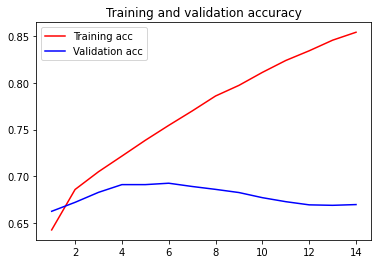

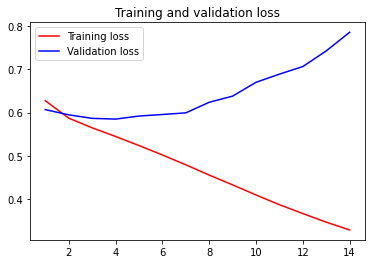

In [ ]:
plot(historyLSTM)

In [ ]:
resultLSTM = modelLSTM.evaluate(test_comment,test_label, batch_size=32)
resultLSTM

313/313 [==============================] - 5s 15ms/step - loss: 0.5882 - accuracy: 0.6878


[0.5881661176681519, 0.6877999901771545]

In [ ]:
test_prediction_lstm=modelLSTM.predict(test_comment)
test_prediction_lstm = np.round(test_prediction_lstm,0).astype(np.int32)
report_lstm = classification_report(test_label, test_prediction_lstm, zero_division=True,labels=[0,1], target_names=["non-sarcastic","sarcastic"])
print(report_lstm)

               precision    recall  f1-score   support



non-sarcastic       0.67      0.74      0.70      5000

    sarcastic       0.71      0.64      0.67      5000



     accuracy                           0.69     10000

    macro avg       0.69      0.69      0.69     10000

 weighted avg       0.69      0.69      0.69     10000




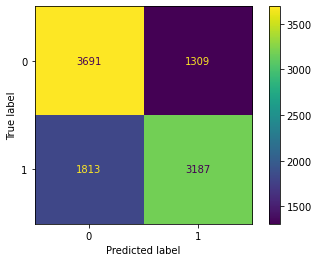

In [ ]:
cf_matrix_lstm = confusion_matrix(test_label,test_prediction_lstm)
disp_lstm = ConfusionMatrixDisplay(confusion_matrix=cf_matrix_lstm,display_labels=[0,1])
disp_lstm.plot()
plt.show()

# BERT

In [ ]:
# get bert processor and model
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [ ]:
epochs = 10
steps_per_epoch = 80000
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 2e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

compile_info_bert = {
    'optimizer': optimizer,
    'loss': 'binary_crossentropy',
    'metrics': ['accuracy'],
}
earlyStopping_bert = EarlyStopping(monitor='val_loss',mode='min',patience=10,restore_best_weights=True)
filepath = 'ep:{epoch:03d}-val_loss:{val_loss:.4f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, verbose=1, mode='min', peroid=5)

training_info_bert = {
    'verbose': 1,
    'epochs': 10,
    'batch_size': 16,
    'callbacks': [earlyStopping_bert,checkpoint]
}



In [ ]:
# this function is for changing the sequence length of bert model
# default=128, sentence longer than 128 will be truncated
class ModifiedBertPreprocess(tf.keras.layers.Layer):
    def __init__(self, max_len):
        super(ModifiedBertPreprocess, self).__init__()
        
        preprocessor = hub.load(
                    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
        
        self.tokenizer = hub.KerasLayer(preprocessor.tokenize, name="tokenizer")
        
        self.prep_layer = hub.KerasLayer(
                             preprocessor.bert_pack_inputs,
                             arguments={"seq_length":max_len})
        
    def call(self, inputs, training):
        tokenized = [self.tokenizer(seq) for seq in inputs]
        return self.prep_layer(tokenized)

In [ ]:
def create_bert_model(compile_info):
  commentInput=Input(shape=(), name="Input", dtype=tf.string)
  processed_inputs = bert_preprocess_model(commentInput)
  encoded_input = bert_layer(processed_inputs)
  poolout =  encoded_input['pooled_output']
  dropout = Dropout(0.2)(poolout)
  out = Dense(1, activation='sigmoid')(dropout)

  model = Model(inputs=commentInput, outputs=out)  
  model.summary()
  model.compile(**compile_info)

  return model
  
modelBERT = create_bert_model(compile_info_bert)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_word_ids':   0           ['Input[0][0]']                  
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

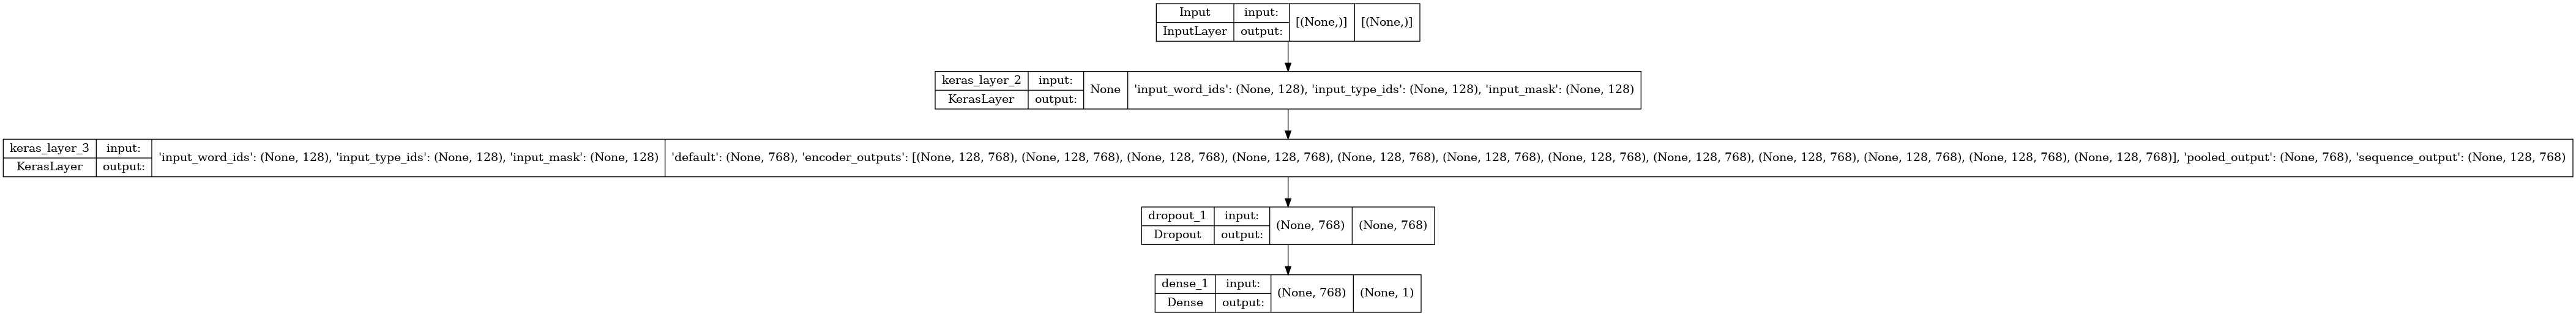

In [ ]:
plot_model(modelBERT, to_file="modelbert.png", show_shapes=True)
display(IPythonImage('modelbert.png'))

In [ ]:
historyBERT = modelBERT.fit(x=train_comment_bert, y=train_label,
                        validation_data=(val_data_comment_bert, val_label),
                        **training_info_bert)

Epoch 1/10
5000/5000 [==============================] - ETA: 0s - loss: 0.6718 - accuracy: 0.5914
Epoch 1: val_loss improved from inf to 0.59194, saving model to ep:001-val_loss:0.5919.h5
5000/5000 [==============================] - 1564s 309ms/step - loss: 0.6718 - accuracy: 0.5914 - val_loss: 0.5919 - val_accuracy: 0.6833
Epoch 2/10
5000/5000 [==============================] - ETA: 0s - loss: 0.5776 - accuracy: 0.6952
Epoch 2: val_loss improved from 0.59194 to 0.55422, saving model to ep:002-val_loss:0.5542.h5
5000/5000 [==============================] - 1546s 309ms/step - loss: 0.5776 - accuracy: 0.6952 - val_loss: 0.5542 - val_accuracy: 0.7097
Epoch 3/10
5000/5000 [==============================] - ETA: 0s - loss: 0.5337 - accuracy: 0.7305
Epoch 3: val_loss improved from 0.55422 to 0.53655, saving model to ep:003-val_loss:0.5365.h5
5000/5000 [==============================] - 1546s 309ms/step - loss: 0.5337 - accuracy: 0.7305 - val_loss: 0.5365 - val_accuracy: 0.7288
Epoch 4/10
500

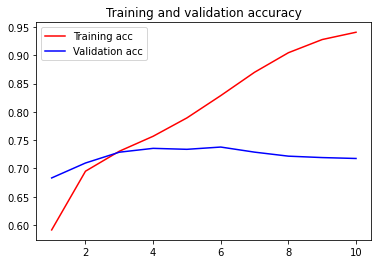

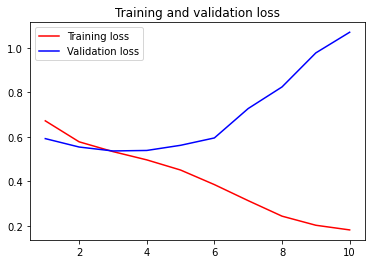

In [ ]:
plot(historyBERT)

In [ ]:
resultBERT = modelBERT.evaluate(test_data_comment_bert,test_label, batch_size=16)
resultBERT

625/625 [==============================] - 70s 111ms/step - loss: 1.0587 - accuracy: 0.7205


[1.0586614608764648, 0.7204999923706055]

In [ ]:
test_prediction_bert = modelBERT.predict(test_data_comment_bert)
test_prediction_bert = np.round(test_prediction_bert,0).astype(np.int32)
report_bert = classification_report(test_label, test_prediction_bert, zero_division=True,labels=[0,1], target_names=["non-sarcastic","sarcastic"])
print(report_bert)

               precision    recall  f1-score   support

non-sarcastic       0.70      0.78      0.74      5000
    sarcastic       0.75      0.66      0.70      5000

     accuracy                           0.72     10000
    macro avg       0.72      0.72      0.72     10000
 weighted avg       0.72      0.72      0.72     10000



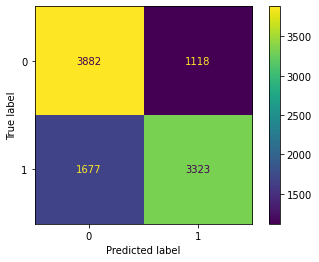

In [ ]:
cf_matrix_bert = confusion_matrix(test_label,test_prediction_bert)
disp_bert = ConfusionMatrixDisplay(confusion_matrix=cf_matrix_bert,display_labels=[0,1])
disp_bert.plot()
plt.show()

# Bert + 3 pretrianed models

In [ ]:
tfhub_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
bert_preprocess_layer = hub.KerasLayer(tfhub_preprocess)
bert_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_model = hub.KerasLayer(bert_url, trainable=True)

In [ ]:
#load pretrained model
sentiment_model = load_model("/content/drive/My Drive/nlp-project/SentimentCheckpoint/sentiment.h5")
emotion_model = load_model("/content/drive/My Drive/nlp-project/EmotionCheckpoint/emotion.h5")
personality_model_EXT = load_model("/content/drive/My Drive/nlp-project/PersonalityCheckpoint/cEXT.h5")
personality_model_NEU = load_model("/content/drive/My Drive/nlp-project/PersonalityCheckpoint/cNEU.h5")
personality_model_AGR = load_model("/content/drive/My Drive/nlp-project/PersonalityCheckpoint/cAGR.h5")
personality_model_CON = load_model("/content/drive/My Drive/nlp-project/PersonalityCheckpoint/cCON.h5")
personality_model_OPN = load_model("/content/drive/My Drive/nlp-project/PersonalityCheckpoint/cOPN.h5")
# bert_model = load_model("/content/drive/My Drive/nlp-project/bertmodel/bert.h5", custom_objects={'KerasLayer':hub.KerasLayer,'AdamWeightDecay': optimizer})

sentiment_intermediate_model = Model(inputs=sentiment_model.input, outputs=sentiment_model.get_layer(index=8).output)
emotion_intermediate_model = Model(inputs=emotion_model.input, outputs=emotion_model.get_layer(index=8).output)
EXT_intermediate_model = Model(inputs=personality_model_EXT.input, outputs=personality_model_EXT.get_layer(index=8).output)
NEU_intermediate_model = Model(inputs=personality_model_NEU.input, outputs=personality_model_NEU.get_layer(index=8).output)
AGR_intermediate_model = Model(inputs=personality_model_AGR.input, outputs=personality_model_AGR.get_layer(index=8).output)
CON_intermediate_model = Model(inputs=personality_model_CON.input, outputs=personality_model_CON.get_layer(index=8).output)
OPN_intermediate_model = Model(inputs=personality_model_OPN.input, outputs=personality_model_OPN.get_layer(index=8).output)

In [ ]:
#pad the sequence for personality model
padded_comments_train = pad_sequences(train_comment, maxlen=1229, padding='post')
padded_comments_test = pad_sequences(test_comment, maxlen=1229, padding='post')
padded_comments_val = pad_sequences(val_comment, maxlen=1229, padding='post')

#get the feature from pre-trained models
s_feature_train = sentiment_intermediate_model.predict(train_comment)
s_feature_test = sentiment_intermediate_model.predict(test_comment)
s_feature_val = sentiment_intermediate_model.predict(val_comment)
e_feature_train = emotion_intermediate_model.predict(train_comment)
e_feature_test = emotion_intermediate_model.predict(test_comment)
e_feature_val = emotion_intermediate_model.predict(val_comment)
EXT_feature_train = EXT_intermediate_model.predict(padded_comments_train)
EXT_feature_test = EXT_intermediate_model.predict(padded_comments_test)
EXT_feature_val = EXT_intermediate_model.predict(padded_comments_val)
NEU_feature_train = NEU_intermediate_model.predict(padded_comments_train)
NEU_feature_test = NEU_intermediate_model.predict(padded_comments_test)
NEU_feature_val = NEU_intermediate_model.predict(padded_comments_val)

AGR_feature_train = AGR_intermediate_model.predict(padded_comments_train)
AGR_feature_test = AGR_intermediate_model.predict(padded_comments_test)
AGR_feature_val = AGR_intermediate_model.predict(padded_comments_val)
CON_feature_train = CON_intermediate_model.predict(padded_comments_train)
CON_feature_test = CON_intermediate_model.predict(padded_comments_test)
CON_feature_val = CON_intermediate_model.predict(padded_comments_val)
OPN_feature_train = OPN_intermediate_model.predict(padded_comments_train)
OPN_feature_test = OPN_intermediate_model.predict(padded_comments_test)
OPN_feature_val = OPN_intermediate_model.predict(padded_comments_val)


In [ ]:
epochs_final = 10
steps_per_epoch = 80000
num_train_steps = steps_per_epoch * epochs_final
num_warmup_steps = int(0.1*num_train_steps)
init_lr = 2e-5
optimizer_final = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

compile_info_final = {
    'optimizer': optimizer_final,
    'loss': 'binary_crossentropy',
    'metrics': ['accuracy'],
}
filepath = '/content/drive/My Drive/nlp-project/bertmodel/final-ep:{epoch:03d}-val_loss:{val_loss:.4f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, verbose=1, mode='min', peroid=5)

training_info_final = {
    'verbose': 1,
    'epochs': 10,
    'batch_size': 16,
    'callbacks': [checkpoint]
}

In [ ]:
def final_model(compile_info):
  commentInput=Input(shape=(), name="Input", dtype=tf.string)
  processed_inputs = bert_preprocess_layer(commentInput)
  encoded_input = bert_model(processed_inputs)
  poolout =  encoded_input['pooled_output']

  s_feature = Input(shape=(100,))
  e_feature = Input(shape=(100,))
  EXT_feature = Input(shape=(100,))
  NEU_feature = Input(shape=(100,))
  AGR_feature = Input(shape=(100,))
  CON_feature = Input(shape=(100,))
  OPN_feature = Input(shape=(100,))

 
  merge = Concatenate()([poolout,s_feature,e_feature,EXT_feature,NEU_feature,AGR_feature,CON_feature,OPN_feature])  
  dropout1 = Dropout(0.2)(merge)
  out = Dense(1, activation='sigmoid')(dropout1)
  
  model = Model(inputs=[commentInput,s_feature,e_feature,EXT_feature,NEU_feature,AGR_feature,CON_feature,OPN_feature], outputs=out)  
  model.summary()
  model.compile(**compile_info)

  return model

In [ ]:
finalModel = final_model(compile_info_final)
historyFinal = finalModel.fit(x=[train_comment_bert,s_feature_train,e_feature_train,EXT_feature_train,NEU_feature_train,AGR_feature_train,CON_feature_train,OPN_feature_train], y=train_label,
                        validation_data=([val_data_comment_bert,s_feature_val,e_feature_val,EXT_feature_val,NEU_feature_val,AGR_feature_val,CON_feature_val,OPN_feature_val], val_label),
                        **training_info_final)


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['Input[0][0]']                  
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                

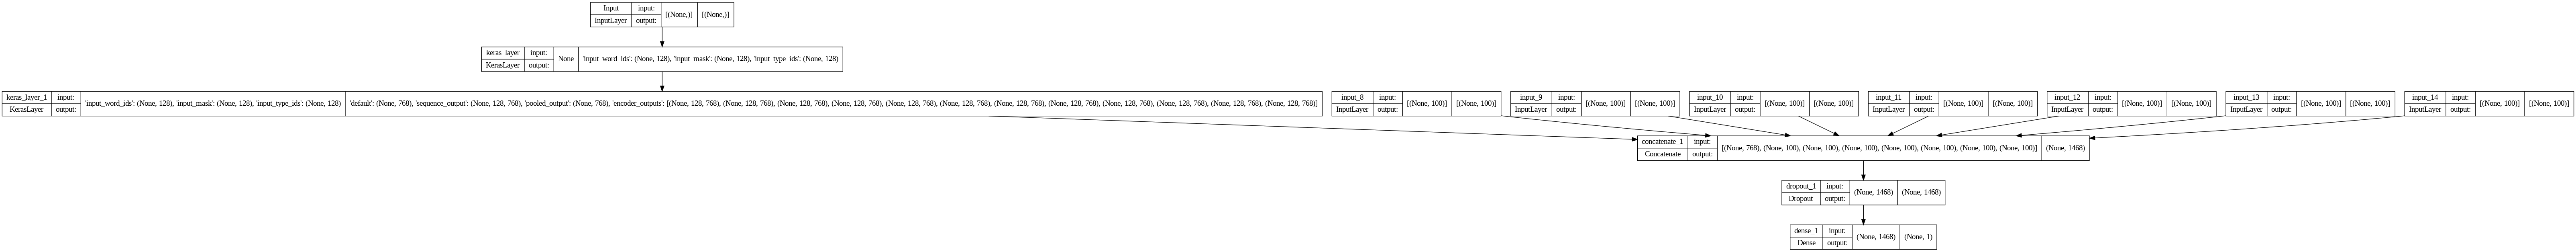

In [ ]:
plot_model(finalModel, to_file="modelfinal.png", show_shapes=True)
display(IPythonImage('modelfinal.png'))

In [ ]:
resultFinal = finalModel.evaluate([test_data_comment_bert,s_feature_test,e_feature_test,EXT_feature_test,NEU_feature_test,AGR_feature_test,CON_feature_test,OPN_feature_test],test_label, batch_size=64)
resultFinal

157/157 [==============================] - 29s 182ms/step - loss: 1.3047 - accuracy: 0.7155


[1.3046844005584717, 0.715499997138977]

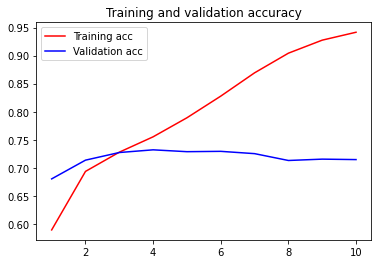

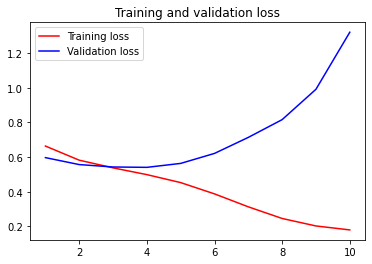

In [ ]:
plot(historyFinal)

In [ ]:
test_prediction_final=finalModel.predict([test_data_comment_bert,s_feature_test,e_feature_test,EXT_feature_test,NEU_feature_test,AGR_feature_test,CON_feature_test,OPN_feature_test])
test_prediction_final = np.round(test_prediction_final,0).astype(np.int32)
report_final = classification_report(test_label, test_prediction_final, zero_division=True,labels=[0,1], target_names=["non-sarcastic","sarcastic"])
print(report_final)

               precision    recall  f1-score   support

non-sarcastic       0.72      0.71      0.71      5000
    sarcastic       0.71      0.72      0.72      5000

     accuracy                           0.72     10000
    macro avg       0.72      0.72      0.72     10000
 weighted avg       0.72      0.72      0.72     10000



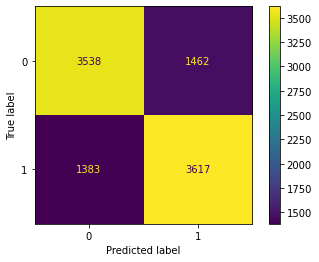

In [ ]:
cf_matrix_final = confusion_matrix(test_label,test_prediction_final)
disp_final = ConfusionMatrixDisplay(confusion_matrix=cf_matrix_final,display_labels=[0,1])
disp_final.plot()
plt.show()

# Bert + 2 pretrained models

In [ ]:
def final_model_without_personality(compile_info):
  commentInput=Input(shape=(), name="Input", dtype=tf.string)
  processed_inputs = bert_preprocess_layer(commentInput)
  encoded_input = bert_model(processed_inputs)
  poolout =  encoded_input['pooled_output']

  s_feature = Input(shape=(100,))
  e_feature = Input(shape=(100,))

  merge = Concatenate()([poolout,s_feature,e_feature])
  dropout1 = Dropout(0.2)(merge)
  out = Dense(1, activation='sigmoid')(dropout1)
  
  model = Model(inputs=[commentInput,s_feature,e_feature], outputs=out)  
  model.summary()
  model.compile(**compile_info)

  return model

In [ ]:
p_test_model = final_model_without_personality(compile_info_final)
history_p_test = p_test_model.fit(x=[train_comment_bert,s_feature_train,e_feature_train], y=train_label,
                        validation_data=([val_data_comment_bert,s_feature_val,e_feature_val], val_label),
                        **training_info_final)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['Input[0][0]']                  
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

In [ ]:
result_p_test = p_test_model.evaluate([test_data_comment_bert,s_feature_test,e_feature_test],test_label, batch_size=16)
result_p_test

625/625 [==============================] - 19s 30ms/step - loss: 1.1299 - accuracy: 0.7221


[1.1298857927322388, 0.722100019454956]

In [ ]:
test_prediction_p = p_test_model.predict([test_data_comment_bert,s_feature_test,e_feature_test])
test_prediction_p = np.round(test_prediction_p,0).astype(np.int32)
report_p = classification_report(test_label, test_prediction_p, zero_division=True,labels=[0,1], target_names=["non-sarcastic","sarcastic"])
print(report_p)

               precision    recall  f1-score   support

non-sarcastic       0.74      0.69      0.71      5000
    sarcastic       0.71      0.75      0.73      5000

     accuracy                           0.72     10000
    macro avg       0.72      0.72      0.72     10000
 weighted avg       0.72      0.72      0.72     10000

